In [2]:
import matplotlib.pyplot as plt
# Import Fastai and Pandas
%matplotlib inline
from fastai.tabular.all import *
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [3]:
# Read training data from csv file into Dataframe
df = pd.read_csv("../data/raw/train.csv")
print(len(df))
print(df.columns)
df

891
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [20]:
# Print columns with missing values
df.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [61]:
# Get count of unique values in categorical columns
len(df.Pclass.unique())
len(df.Name.unique())
len(df.Sex.unique())
len(df.Ticket.unique())
len(df.Cabin.unique())
df.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [92]:
def plot_feature_against_survived(feature_name, ax, buckets=None):
    if not buckets:
        df[[feature_name, 'Survived']].groupby([feature_name]).mean().plot.bar(ax=ax)
    else:
        df[[feature_name, "Survived"]].groupby(pd.cut(df[feature_name], buckets)).mean().drop(feature_name, axis=1).plot.bar(ax=ax)

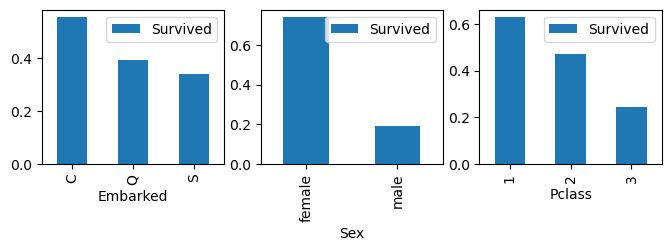

In [96]:
# Compare Survived against categorical features
figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,2))

plot_feature_against_survived("Embarked", ax[0])
plot_feature_against_survived("Sex", ax[1])
plot_feature_against_survived("Pclass", ax[2])

In [94]:
print(df.SibSp.unique())
print(df.Parch.unique())
print(df.Fare.min(), df.Fare.max())

[1 0 3 4 2 5 8]
[0 1 2 5 3 4 6]
0.0 512.3292


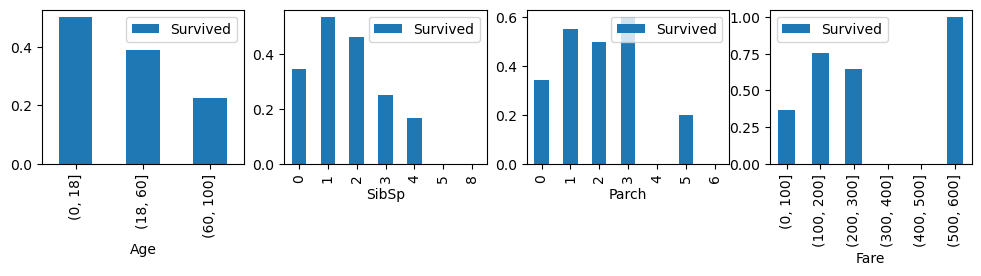

In [95]:
# Compare survived against continuous features

LEGAL_ADULT_AGE = 18
SENIOR_AGE = 60

figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,2))

plot_feature_against_survived("Age", ax[0], [0, LEGAL_ADULT_AGE, SENIOR_AGE, 100])
plot_feature_against_survived("SibSp", ax[1])
plot_feature_against_survived("Parch", ax[2])
plot_feature_against_survived("Fare", ax[3], [x*100 for x in range(7)])


In [150]:
# Get Cabin types from column and compare against Survived
def get_cabin_type(cabins: str):
    if pd.isna(cabins):
        return "NC"
    else:
        return cabins.split(" ")[0][0]

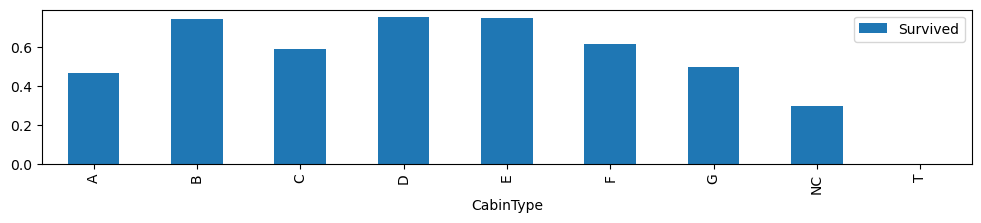

In [155]:
df["CabinType"] = df["Cabin"].apply(get_cabin_type)

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,2))
plot_feature_against_survived("CabinType", ax)

In [99]:
categorical_features = ["Pclass", "Sex", "Embarked", "CabinType"]
continuous_features = ["Age", "SibSp", "Parch", "Fare"]
tabular_processors = [Categorify, FillMissing, Normalize]
y_variable = "Survived"
prediction_columns = {"PassengerId", "Survived"}

In [111]:
# Create transformation methods to be applied to dataframe
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))

In [112]:
# Create TabularDataLoader for the loaded DataFrame
tabular_dls = TabularDataLoaders.from_df(df,
                                         cat_names=categorical_features,
                                         cont_names=continuous_features,
                                         y_names=y_variable,
                                         splits=splits,
                                         procs=tabular_processors)

tabular_dls.train.show_batch()

,Pclass,Sex,Embarked,Age_na,Age,SibSp,Parch,Fare,Survived
0,1,female,C,False,44.000000,-1.253675e-08,1.000000e+00,57.979198,1.0
1,3,male,S,False,31.000000,-1.253675e-08,1.228731e-08,7.925000,1.0
2,1,female,C,True,28.000000,-1.253675e-08,1.228731e-08,110.883298,1.0
3,1,female,S,False,49.000000,-1.253675e-08,1.228731e-08,25.929200,1.0
4,2,male,S,False,54.000000,-1.253675e-08,1.228731e-08,26.000000,0.0
5,1,male,S,False,33.000000,-1.253675e-08,1.228731e-08,5.000000,0.0
6,1,female,C,False,39.000000,1.000000e+00,1.000000e+00,110.883298,1.0
7,2,male,S,False,66.000001,-1.253675e-08,1.228731e-08,10.500000,0.0
8,3,female,C,False,14.500000,1.000000e+00,1.228731e-08,14.454199,0.0
9,3,female,Q,True,28.000000,1.000000e+00,1.228731e-08,15.499999,1.0


In [103]:
# Fit data to Random Forest using default config
rf_classifier = RandomForestClassifier()
rf_classifier.fit(tabular_dls.train.xs, tabular_dls.train.y)

RandomForestClassifier()

In [132]:
# Make predictions on validation set
rf_classifier.score(tabular_dls.valid.xs, tabular_dls.valid.y)

0.8707865168539326

In [171]:
# Display confusion matrix on validation set
valid_pred = rf_classifier.predict(tabular_dls.valid.xs)
valid_pred = pd.DataFrame({"Survived": valid_pred})
metrics.confusion_matrix(tabular_dls.valid.y, valid_pred)

array([[100,   5],
       [ 18,  55]])

In [133]:
test_df = pd.read_csv("../data/raw/test.csv")

In [138]:
test_df.isna().any()

# We see that Fare has missing values, which is not the case for the training data.
# Dataloader throws an error because it doesn't know how to apply the transformations for this column

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [139]:
# Fill Fare column
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)

In [140]:
test_dl = tabular_dls.test_dl(test_items=test_df)

In [143]:
# Get test predictions for RF
test_pred = rf_classifier.predict(test_dl.xs)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,

In [149]:
# Create csv with passenger Ids and predictions
test_pred_df = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived": test_pred})
test_pred_df.to_csv("../data/predictions/rf_default_pred.csv", index=False)